In [36]:
import sys
sys.path.append('../src')
from utils import dag_utils 
from show.model import brasil_model
from show.model import worl_model
import requests
import json
import pandas as pd

## Get Brasil e World Model

In [37]:
brasil = brasil_model.BrasilDada(config_data_path='..')
#world = worl_model.WorldHealth(config_data_path='..')
brasil_data = brasil.db
#world_data = world.db

### Interiorização

**Pegando obitos**

In [38]:
city = 'SP'
place_type = 'state'

In [39]:
query = f"SELECT date,sum(new_deaths) as deaths FROM casos_full WHERE {place_type} = '{city}' group by(date)"
df_estado = brasil_data.execute_query(query)
df_estado.head()

,date,deaths
0,2020-02-25,0.0
1,2020-02-26,0.0
2,2020-02-27,0.0
3,2020-02-28,0.0
4,2020-02-29,0.0


**Pegados dados da cidade**

In [47]:
place_type = 'state'
city = 'SP'

query = f"SELECT * FROM casos_full WHERE {place_type} = '{city}'"
df_cidades = brasil_data.execute_query(query)
df_cidades.head()

#data_dict
link = f'https://servicodados.ibge.gov.br/api/v1/localidades/estados/{city}/distritos'
data_dict = requests.get(link).json()

city_dict = {}
for data_cidade in data_dict:
    cidade = data_cidade['municipio']['nome']
    regiao = data_cidade['municipio']['microrregiao']['mesorregiao']['nome']
    city_dict[cidade] = regiao

def set_tipo_regiao(cidade):
    if cidade in city_dict and 'Metropolitana' in city_dict[cidade]:
        return 'capital' 
    else:
        return 'interior' 


**comparar capital e interior**

In [41]:
df_cidades['tipo_reg'] = df_cidades['city'].apply(set_tipo_regiao)

In [42]:
df_cidades.groupby('tipo_reg').sum()['new_deaths']

tipo_reg
capital     16925
interior    25487
Name: new_deaths, dtype: int64

**Grafico temporal**

In [43]:
import matplotlib.pyplot as plt

In [44]:
interior = df_cidades[df_cidades['tipo_reg'] == 'interior']
interior_date = interior.groupby('date').sum()['new_deaths']
interior_date.index = pd.to_datetime(interior_date.index)

capital = df_cidades[df_cidades['tipo_reg'] == 'capital']
capital_date = capital.groupby('date').sum()['new_deaths']
capital_date.index = pd.to_datetime(capital_date.index)

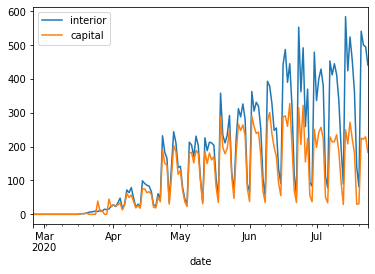

In [45]:
interior_date.plot(label='interior')
capital_date.plot(label='capital')
plt.legend()

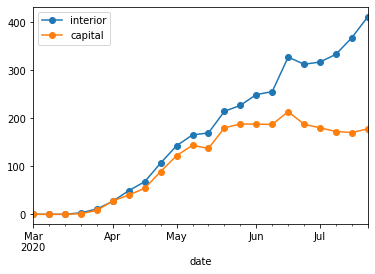

In [46]:
interior_date.groupby(pd.Grouper(freq='w')).mean().plot(label='interior',marker='o')
capital_date.groupby(pd.Grouper(freq='w')).mean().plot(label='capital',marker='o')
plt.legend()

## Função

In [146]:

def set_tipo_regiao(cidade,city_dict):
    if cidade in city_dict and 'Metropolitana' in city_dict[cidade]:
        return 'capital' 
    else:
        return 'interior' 

    
def interior_vs_capital(estado,tipo_coparacao,mensal=False,porcentagem=False):
    query = f"SELECT * FROM casos_full WHERE state = '{estado}'"
    df_cidades = brasil_data.execute_query(query)

    #data_dict
    link = f'https://servicodados.ibge.gov.br/api/v1/localidades/estados/{estado}/distritos'
    data_dict = requests.get(link).json()

    city_dict = {}
    for data_cidade in data_dict:
        cidade = data_cidade['municipio']['nome']
        regiao = data_cidade['municipio']['microrregiao']['mesorregiao']['nome']
        city_dict[cidade] = regiao
        
    df_cidades['tipo_reg'] = df_cidades['city'].apply(lambda x : set_tipo_regiao(x,city_dict))
    
    #pegando interior
    interior = df_cidades[df_cidades['tipo_reg'] == 'interior']
    interior_date = interior.groupby('date').sum()[tipo_coparacao]
    interior_date.index = pd.to_datetime(interior_date.index)
    #pegando capital
    capital = df_cidades[df_cidades['tipo_reg'] == 'capital']
    capital_date = capital.groupby('date').sum()[tipo_coparacao]
    capital_date.index = pd.to_datetime(capital_date.index)
    if porcentagem:
        capital_date = capital_date / (capital_date+interior_date)
        interior_date = 1 - capital_date
    if mensal:
        interior_date.groupby(pd.Grouper(freq='w')).mean().plot(label='interior',marker='o')
        capital_date.groupby(pd.Grouper(freq='w')).mean().plot(label='capital',marker='o')
    else:
        interior_date.plot(label='interior')
        capital_date.plot(label='capital')
    plt.legend()

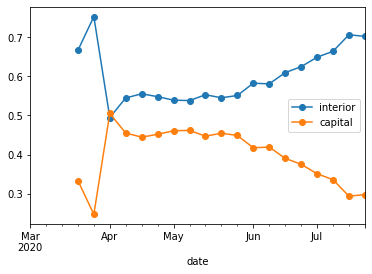

In [148]:
interior_vs_capital('SP','new_deaths',True,True)

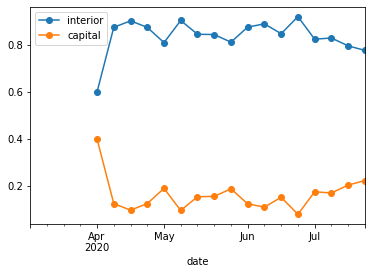

In [149]:
interior_vs_capital('MG','new_deaths',True,True)

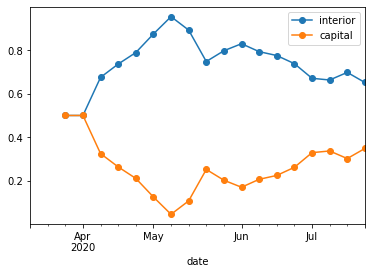

In [150]:
interior_vs_capital('RS','new_deaths',True,True)

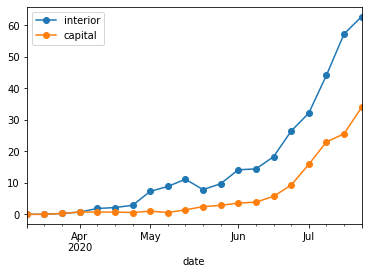

In [132]:
x = interior_vs_capital('RS','new_deaths',True)

In [88]:
interior_vs_capital('SP','new_deaths',True)

NameError: name 'x' is not defined

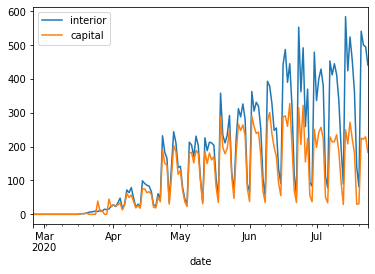

In [59]:
interior_date.plot(label='interior')
capital_date.plot(label='capital')
plt.legend()

## Ajuda

**Verificando região po municipio**

In [65]:
state = 'SP'

In [66]:
data_dict = requests.get(link).json()

In [68]:
data_dict

[{'id': 350010505,
  'nome': 'Adamantina',
  'municipio': {'id': 3500105,
   'nome': 'Adamantina',
   'microrregiao': {'id': 35035,
    'nome': 'Adamantina',
    'mesorregiao': {'id': 3508,
     'nome': 'Presidente Prudente',
     'UF': {'id': 35,
      'sigla': 'SP',
      'nome': 'São Paulo',
      'regiao': {'id': 3, 'sigla': 'SE', 'nome': 'Sudeste'}}}}}},
 {'id': 350020405,
  'nome': 'Adolfo',
  'municipio': {'id': 3500204,
   'nome': 'Adolfo',
   'microrregiao': {'id': 35004,
    'nome': 'São José do Rio Preto',
    'mesorregiao': {'id': 3501,
     'nome': 'São José do Rio Preto',
     'UF': {'id': 35,
      'sigla': 'SP',
      'nome': 'São Paulo',
      'regiao': {'id': 3, 'sigla': 'SE', 'nome': 'Sudeste'}}}}}},
 {'id': 350030305,
  'nome': 'Aguaí',
  'municipio': {'id': 3500303,
   'nome': 'Aguaí',
   'microrregiao': {'id': 35029,
    'nome': 'Pirassununga',
    'mesorregiao': {'id': 3507,
     'nome': 'Campinas',
     'UF': {'id': 35,
      'sigla': 'SP',
      'nome': 'São Pa

In [67]:
def set_type_city(state,df_estados):
    capital = df_estados[df_estados['Sigla']=='SP']['Capital'].iloc[0]
    link = f'https://servicodados.ibge.gov.br/api/v1/localidades/estados/{state}/distritos'
    data_dict = requests.get(link).json()
    for data_cidade in data_dict:
        cidade = data_cidade['municipio']['nome']
        regiao = data_cidade['municipio']['microrregiao']['nome']
        tipo = 'Capital' if regiao == capital else 'Interior'
        print(f"Municipio: {cidade}\n\tregiao: {tipo}")
set_type_city('SP',estados)

Municipio: Adamantina
	regiao: Interior
Municipio: Adolfo
	regiao: Interior
Municipio: Aguaí
	regiao: Interior
Municipio: Águas da Prata
	regiao: Interior
Municipio: Águas da Prata
	regiao: Interior
Municipio: Águas de Lindóia
	regiao: Interior
Municipio: Águas de Santa Bárbara
	regiao: Interior
Municipio: Águas de São Pedro
	regiao: Interior
Municipio: Agudos
	regiao: Interior
Municipio: Agudos
	regiao: Interior
Municipio: Alambari
	regiao: Interior
Municipio: Alfredo Marcondes
	regiao: Interior
Municipio: Altair
	regiao: Interior
Municipio: Altair
	regiao: Interior
Municipio: Altinópolis
	regiao: Interior
Municipio: Alto Alegre
	regiao: Interior
Municipio: Alto Alegre
	regiao: Interior
Municipio: Alto Alegre
	regiao: Interior
Municipio: Alumínio
	regiao: Interior
Municipio: Álvares Florence
	regiao: Interior
Municipio: Álvares Florence
	regiao: Interior
Municipio: Álvares Machado
	regiao: Interior
Municipio: Álvares Machado
	regiao: Interior
Municipio: Álvaro de Carvalho
	regiao: Int

In [74]:
link = f'https://servicodados.ibge.gov.br/api/v1/localidades/estados/PE/distritos'
data_dict = requests.get(link).json()
for data_cidade in data_dict:
    cidade = data_cidade['municipio']['nome']
    if cidade == 'Recife':
        regiao = data_cidade['municipio']['microrregiao']['mesorregiao']['nome']
        print(regiao)

Metropolitana de Recife


# Extras

## Pegando estados

In [44]:
import pandas as pd

In [49]:
dfs = pd.read_html('https://www.estadosecapitaisdobrasil.com/')
estados = dfs[0]
estados.drop('Bandeira',axis=1,inplace=True)

In [51]:
estados.to_csv('estados.csv')

In [52]:
estados

,Estado,Sigla,Capital,Região
0,Acre,AC,Rio Branco,Norte
1,Alagoas,AL,Maceió,Nordeste
2,Amapá,AP,Macapá,Norte
3,Amazonas,AM,Manaus,Norte
4,Bahia,BA,Salvador,Nordeste
5,Ceará,CE,Fortaleza,Nordeste
6,Distrito Federal,DF,Brasília,Centro-Oeste
7,Espírito Santo,ES,Vitória,Sudeste
8,Goiás,GO,Goiânia,Centro-Oeste
9,Maranhão,MA,São Luís,Nordeste


In [72]:

estados[estados['Sigla']=='SP']['Capital'].iloc[0]

'São Paulo'